In [77]:
# https://www.tensorflow.org/tutorials/load_data/images
# https://keras.io/api/preprocessing/image/
# https://www.tensorflow.org/tutorials/keras/classification
# https://www.tensorflow.org/guide/keras/save_and_serialize
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import matplotlib.pyplot as plt

In [78]:
print(tf.__version__)

2.10.0


In [79]:
# Loading images

batch_size = 32
img_height = 32
img_width = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  "dataset/train",
  labels="inferred",
  validation_split=0.8,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "dataset/train",
  labels="inferred",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  "dataset/test",
  labels="inferred",
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size
)

class_names = train_ds.class_names
print("Class Names: ")
print(class_names)


Found 10901 files belonging to 6 classes.
Using 2181 files for training.
Found 10901 files belonging to 6 classes.
Using 2180 files for validation.
Found 2698 files belonging to 6 classes.
Class Names: 
['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


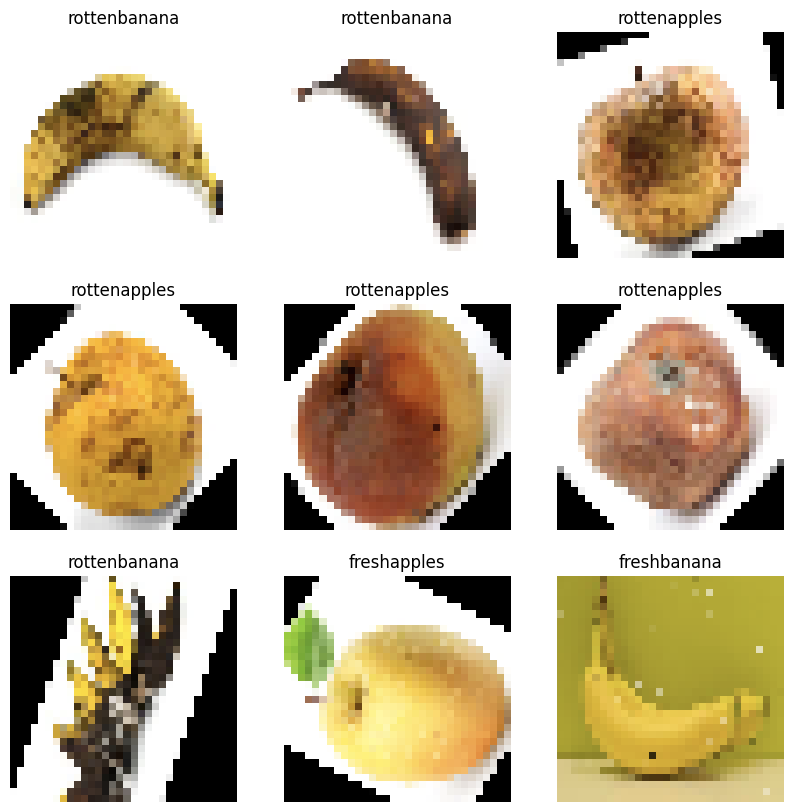

In [80]:
# Visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [81]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [82]:
# Setting up layers
num_classes = 6

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [83]:
# Compiling model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [84]:
# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [85]:
# Normalization

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("Training data:")
print(np.min(first_image), np.max(first_image))

normalized_val_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_val_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("Validation data:")
print(np.min(first_image), np.max(first_image))

normalized_test_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_test_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print("Test data:")
print(np.min(first_image), np.max(first_image))

Training data:
0.0 0.987784
Validation data:
0.0 1.0
Test data:
0.019914508 1.0


In [86]:
# Training/feeding the model

model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=10)

Epoch 1/10
69/69 [==============================] - 21s 273ms/step - loss: 1.4542 - accuracy: 0.4260 - val_loss: 1.0626 - val_accuracy: 0.5961
Epoch 2/10
69/69 [==============================] - 19s 260ms/step - loss: 0.9258 - accuracy: 0.6566 - val_loss: 0.8352 - val_accuracy: 0.6699
Epoch 3/10
69/69 [==============================] - 18s 259ms/step - loss: 0.7685 - accuracy: 0.7148 - val_loss: 0.6706 - val_accuracy: 0.7515
Epoch 4/10
69/69 [==============================] - 16s 218ms/step - loss: 0.6323 - accuracy: 0.7740 - val_loss: 0.5508 - val_accuracy: 0.8024
Epoch 5/10
69/69 [==============================] - 20s 279ms/step - loss: 0.5981 - accuracy: 0.7895 - val_loss: 0.5381 - val_accuracy: 0.8166
Epoch 6/10
69/69 [==============================] - 18s 240ms/step - loss: 0.5131 - accuracy: 0.8221 - val_loss: 0.4519 - val_accuracy: 0.8455
Epoch 7/10
69/69 [==============================] - 22s 307ms/step - loss: 0.4498 - accuracy: 0.8446 - val_loss: 0.4527 - val_accuracy: 0.8290

In [87]:
# Evaluating accuracy on test dataset

test_loss, test_acc = model.evaluate(normalized_test_ds, verbose=2)

print('\nTest accuracy:', test_acc)


69/69 - 8s - loss: 0.3836 - accuracy: 0.8624 - 8s/epoch - 116ms/step

Test accuracy: 0.8624483942985535


In [88]:
# Saving model
model.save("fruit_neural_network.h5")